# Plots for MacNeil et al. Water quality limits on the GBR


In [1]:
# Import python packages
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
# Change this to your own anaconda location to get around Basemap error
os.environ['PROJ_LIB'] = '/Users/aaronmacneil/anaconda/share/proj'
import seaborn as sns
import matplotlib as mp
import numpy.random as npr
import matplotlib.patches as mpatches
from scipy.interpolate import interp1d
from mpl_toolkits.basemap import Basemap as bm
import datetime as dt
from scipy.stats.kde import gaussian_kde
import matplotlib.path as mpath
import scipy as sp
import cmocean as cmo
import sqlite3
import pdb
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.patches import PathPatch
#mp.pyplot.style.use('ggplot')
mp.pyplot.style.use('seaborn-darkgrid')

### Import data as per analyses

In [2]:
# Helper functions
def indexall(L):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    return poo,Ix

def subindexall(short,long):
    poo = []
    out = []
    for s,l in zip(short,long):
        if not l in poo:
            poo.append(l)
            out.append(s)
    return indexall(out)

match = lambda a, b: np.array([ b.index(x) if x in b else None for x in a ])
grep = lambda s, l: np.array([i for i in l if s in i])

# Function to standardize covariates
def stdize(x):
    return (x-np.mean(x))/(2*np.std(x))

def SMA(array):
    return npr.choice(array)

def SMX(matrix,indx):
    return npr.choice(matrix[matrix.columns[indx]].values)

def gelplot(pj,vector,posy,csize=40,lwd50=7,lwd95=1):

    if np.percentile(vector,2.5)<0 and 0<np.percentile(vector,97.5):
    #if np.percentile(vector,25)<0 and 0<np.percentile(vector,75):
        pj.plot((np.percentile(vector,2.5),np.percentile(vector,97.5)),(posy,posy),linewidth=lwd95,c='grey')
        pj.plot((np.percentile(vector,25),np.percentile(vector,75)),(posy,posy),linewidth=lwd50,c='grey')
        pj.plot(np.median(vector),posy,'.',markersize=csize,c='grey')
    else:
        pj.plot((np.percentile(vector,2.5),np.percentile(vector,97.5)),(posy,posy),linewidth=lwd95,c='black')
        pj.plot((np.percentile(vector,25),np.percentile(vector,75)),(posy,posy),linewidth=lwd50,c='black')
        pj.plot(np.median(vector),posy,'.',markersize=csize,c='black')

In [3]:
# Import ltmp data
xdata = pd.read_csv('GBR_ltmp.csv')

# Get rid of missing years
xdata = xdata.loc[xdata.HC >= 0]
# Set reefyear
reefyear = np.array([r+str(y) for r,y in zip(xdata.REEF_NAME.values,xdata.REPORT_YEAR.values)])
# Create new cluster code column
xdata['ClustCode'] = xdata.CLUSTER.values
# Substitute ClusterNames for Cluster codes
Clust_dict = ['CL1','CL2','CL3','CL4']
Clust_names = np.array(['Porities-A','Mixed','Soft-coral','Acropora'])
xdata['CLUSTER'] = np.array(Clust_names)[match(xdata.ClustCode.values,Clust_dict)]
xdata['reefNyear'] = xdata.REEF_NAME+'_'+xdata.REPORT_YEAR.astype(str)

In [4]:
# Hard coral - out of 200 points
HC = np.round(xdata.HC.values)+1
nobs = len(HC)

# Lag-1 hard coral
HC1 = np.round(xdata.HC_1.values)+1

# log lag-1 hard coral
lHC = np.log(HC)
lHC1 = np.log(HC1)

# Number of observations
nobs = len(lHC1)

# Make missing disturbances 'Unknown'
Dist_ = xdata.DISTURBANCE.values
Dist_[Dist_=='-999'] = 'U'
# Create unknown disturbance array
UNK = (Dist_=='U')*1

# CoTS outbreaks
CoTS = stdize(np.log(xdata.C.values+1))
CoTS_1 = xdata.COTS.values

# Cyclones
STORM = stdize(np.log(xdata.S.values+1))
STORM_1 = xdata.STORM.values

# Bleaching
BLEACH = stdize(np.log(xdata.B.values+1))
BLEACH_1 = xdata.BLEACHING.values

# Disease
DISEASE = stdize(np.log(xdata.D.values+1))
DISEASE_1 = xdata.DISEASE.values

# log-Herbivory
tmp = xdata.HERB.values
tmp[tmp==-999] = np.mean(tmp[tmp!=-999])
HERB = stdize(np.log(tmp+1))
# Year
year = xdata.REPORT_YEAR.values
nyears = len(np.unique(year))
YR = xdata.REPORT_YEAR.values-1995
maxyr = max(YR)

# Index each reef to a given cluster
Clusterx,Ic = subindexall(xdata.CLUSTER.values,xdata.REEF_NAME.values)
ncluster = len(Clusterx)

# Index each transect to a given reef
Reef,Ir = indexall(xdata.REEF_NAME.values)
nreefs = len(Reef)

# Reef per year
ReefYear,Iry = indexall(xdata.reefNyear.values)
nreefyr = len(ReefYear)

# Index each transect to a given cluster
Cluster_t,Ict = indexall(xdata.CLUSTER.values)
nct = len(Cluster_t)

# Get shelf position for each reef
Shelf,Is = indexall(xdata.SHELF.values)
nshelf = len(Shelf)

# Disturbance array
DIST = ['CoTS','Cyclones','Bleaching','Disease','Unknown']

# Index constant reef-scale covariates
rindx = np.array([list(xdata.REEF_NAME.values).index(x) for x in Reef])

# Get water quality values
WQ = xdata.PFsum.values[rindx]
# Mean water quality per cluster
Mean_wq = np.array([np.mean(WQ[Ic==i]) for i in range(ncluster)])
# Log water quality
lWQ = np.log(WQ)
# Zero-centred water quality per cluster
ZcWQ = WQ-Mean_wq[Ic]

# Get zoning for resistance
ZONE = (xdata.iZONE.values+xdata.sZONE.values>0)*1
# Get zoning values for recovery
rZONE = ZONE[rindx]

# Index year-varying reef-scale covariates
ryindx = np.array([list(xdata.REEF_NAME.values).index(x) for x in Reef])

/Users/aaronmacneil/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.


In [5]:
np.shape(xdata), nreefs

((12523, 39), 46)

## Quantities quoted in paper

In [6]:
# Observed average coral cover in 1995 and 2017
np.mean(HC[year==1995]), np.mean(HC[year==2017])

(28.05, 28.6231884057971)

In [7]:
# Net and proportional changes
np.mean(HC[year==1995])-np.mean(HC[year==2017]), np.mean(HC[year==2017])/np.mean(HC[year==1995])

(-0.5731884057971008, 1.0204345242708415)

In [8]:
# Mean water quality per cluster
Mean_wq = np.array([np.mean(WQ[Ic==i]) for i in range(ncluster)])
Mean_wq

array([0.56615158, 0.27384845, 0.082935  , 0.06295335])

## Get traces for model parameters and results

In [9]:
# Import disturbance results
Dresults = pd.read_csv('Disturbance_results.csv')
# Import Gompertz results
Gresults = pd.read_csv('Gompertz_results.csv')

In [10]:
# Export summary statistics for Gompertz results
Gresults.quantile((0.5,.25,.975)).rename(index={0.5: 'Median',0.25: 'Low 95',0.975: 'Upp 95'}).to_csv('Gompertz_summary_stats.csv')
Dresults.quantile((0.5,.25,.975)).rename(index={0.5: 'Median',0.25: 'Low 95',0.975: 'Upp 95'}).to_csv('Disturbance_summary_stats.csv')

In [11]:
# Load reef simulation results
HC_projection = np.load("HC_projection.dat")
HC_projection_wq = np.load("HC_projection_wq.dat")
WQ_projection = np.load("WQ_projection.dat")

# Load bleaching results 
HC_projection_b1 = np.load("HC_projection_b1.dat")
HC_projection_wq_b1 = np.load("HC_projection_wq_b1.dat")
WQ_projection_b1 = np.load("WQ_projection_b1.dat")

HC_projection_b2 = np.load("HC_projection_b2.dat")
HC_projection_wq_b2 = np.load("HC_projection_wq_b2.dat")
WQ_projection_b2 = np.load("WQ_projection_b2.dat")

HC_projection_b3 = np.load("HC_projection_b3.dat")
HC_projection_wq_b3 = np.load("HC_projection_wq_b3.dat")
WQ_projection_b3 = np.load("WQ_projection_b3.dat")

HC_projection_b4 = np.load("HC_projection_b4.dat")
HC_projection_wq_b4 = np.load("HC_projection_wq_b4.dat")
WQ_projection_b4 = np.load("WQ_projection_b4.dat")

In [12]:
# Observed average WQ per cluster
muWQ = np.array([np.mean(WQ[Ic==i]) for i in range(ncluster)])
# Observed average zone per cluster
muZ = np.array([np.mean(rZONE[Ic==i]) for i in range(ncluster)])
# Observed average disturbances per cluster
muC = np.array([np.mean(CoTS[Ict==i]) for i in range(ncluster)])
muS = np.array([np.mean(STORM[Ict==i]) for i in range(ncluster)])
muB = np.array([np.mean(BLEACH[Ict==i]) for i in range(ncluster)])
muD = np.array([np.mean(DISEASE[Ict==i]) for i in range(ncluster)])
muU = np.array([np.mean(UNK[Ict==i]) for i in range(ncluster)])

In [13]:
# Initial 2017 cluster-averaged cover
HC_2017 = np.array([np.median(HC[Ict==i]) for i in range(ncluster)])
HC_2017

array([21., 33., 36., 24.])

In [14]:
muWQ

array([0.56615158, 0.27384845, 0.082935  , 0.06295335])

In [15]:
# Disturbance probabilites
p_cots = Dresults[list(grep('p_cots',Dresults.columns.values))]
p_cots.columns = Clusterx

p_storms = Dresults[list(grep('p_storms',Dresults.columns.values))]
p_storms.columns = Clusterx

p_bleach = Dresults[list(grep('p_bleach',Dresults.columns.values))]
p_bleach.columns = Clusterx

p_disease = Dresults[list(grep('p_disease',Dresults.columns.values))]
p_disease.columns = Clusterx

p_unknown = Dresults[list(grep('p_unknown',Dresults.columns.values))]
p_unknown.columns = Clusterx

In [16]:
# Current probability of bleaching
p_bleach.median()

Porities-A    0.022518
Mixed         0.023885
Acropora      0.000305
Soft-coral    0.021776
dtype: float64

In [17]:
xdata.groupby('CLUSTER')['COTS'].mean()

CLUSTER
Acropora      0.017696
Mixed         0.041297
Porities-A    0.045872
Soft-coral    0.030529
Name: COTS, dtype: float64

In [18]:
list(p_cots.columns.values)

['Porities-A', 'Mixed', 'Acropora', 'Soft-coral']

In [19]:
Clust_x = ['Porities-A', 'Mixed', 'Soft-coral', 'Acropora']

In [20]:
# Re-order to match modelling results
p_cots = p_cots[Clust_x]
p_storms = p_storms[Clust_x]
p_bleach = p_bleach[Clust_x]
p_disease = p_disease[Clust_x]
p_unknown = p_unknown[Clust_x]

In [21]:
# Model estimates
r_Cluster = Gresults[Gresults.columns[match(['r_'+c for c in Clust_x],list(Gresults.columns.values))]]
r_Cluster.columns = [R[2:] for R in r_Cluster.columns]
r_Reef = Gresults[list(grep('r_',Gresults.columns.values))]

a_Cluster = Gresults[Gresults.columns[match(['a_'+c for c in Clust_x],list(Gresults.columns.values))]]
a_Cluster.columns = [a[2:] for a in a_Cluster.columns]
a_Reef = Gresults[list(grep('a_',Gresults.columns.values))]

In [22]:
# Reset cluster names to order in model resutls
Cluster = list(a_Cluster.columns)

In [23]:
# Covariates
beta_zone = Gresults[Gresults.columns[list(Gresults.columns.values).index('Zone')]].values
beta_WQ = Gresults[Gresults.columns[list(Gresults.columns.values).index('WQ')]].values
beta_herb = Gresults[Gresults.columns[list(Gresults.columns.values).index('Herbivory')]].values

beta_CoTS = Gresults[Gresults.columns[list(Gresults.columns.values).index('CoTS')]].values
beta_cots = Gresults[Gresults.columns[match(['cots_'+c for c in Clust_x],list(Gresults.columns.values))]]
beta_Storms = Gresults[Gresults.columns[list(Gresults.columns.values).index('Storms')]].values
beta_storms = Gresults[Gresults.columns[match(['Storm_'+s for s in Shelf],list(Gresults.columns.values))]]
beta_Bleach = Gresults[Gresults.columns[list(Gresults.columns.values).index('Bleaching')]].values
beta_Disease = Gresults[Gresults.columns[list(Gresults.columns.values).index('Disease')]].values
beta_Unknown = Gresults[Gresults.columns[list(Gresults.columns.values).index('Unknown')]].values
beta_cots_wq = Gresults[Gresults.columns[list(Gresults.columns.values).index('WQ_CoTS')]].values
beta_bleach_wq = Gresults[Gresults.columns[list(Gresults.columns.values).index('WQ_bleach')]].values
beta_disease_wq = Gresults[Gresults.columns[list(Gresults.columns.values).index('WQ_Disease')]].values
beta_unknown_wq = Gresults[Gresults.columns[list(Gresults.columns.values).index('WQ_Unknown')]].values
beta_cots_ca = Gresults[Gresults.columns[list(Gresults.columns.values).index('Z_CoTS')]].values
beta_bleach_ca = Gresults[Gresults.columns[list(Gresults.columns.values).index('Z_bleach')]].values
beta_disease_ca = Gresults[Gresults.columns[list(Gresults.columns.values).index('Z_Disease')]].values
beta_unknown_ca = Gresults[Gresults.columns[list(Gresults.columns.values).index('Z_Unknown')]].values

# Quantities

In [24]:
# Percentage of closed reefs
sum(rZONE)/len(rZONE)

0.34782608695652173

In [25]:
# McCullugh et al. plume load estimates
Modern_plume = 4.8+0.6*10**12
PreEuro_plume = 3.5+0.2*10**12
Euro_delta = PreEuro_plume/Modern_plume
max_PFx = (1-Euro_delta)*100
max_PF = max_PFx/100
max_PFx

66.66666666635001

In [26]:
# Brodie et al. load estimates for all areas south of Cape York NRM Region

# From Table 10 of Brodie et al. 2017
DIN_ratio = np.mean([2750/5496,1297/2574,902/1355,186/1140,854/1040])
# From Table 11 of Brodie et al. 2017
FS_ratio = np.mean([936/1516,3209/3781,589/818,1568/1824,1192/1459])

max_PFx = np.mean([DIN_ratio,FS_ratio])*100
max_PFx

65.17070787565274

In [27]:
# Intrinsic rate of increase (r)
tmp = r_Cluster.quantile((0.5,.25,.975)).rename(index={0.5: 'Median',0.25: 'Low 95',0.975: 'Upp 95'})
tmp

,Porities-A,Mixed,Soft-coral,Acropora
Median,1.130032,1.082043,1.048337,1.478950
Low 95,1.007183,0.968857,0.967087,1.358360
Upp 95,1.444290,1.441014,1.294062,1.886778


In [28]:
# Recovery rates relative to Acropora
tmp['Acropora']/tmp['Porities-A'], tmp['Acropora']/tmp['Soft-coral'], tmp['Acropora']/tmp['Mixed']

(Median    1.308767
 Low 95    1.348673
 Upp 95    1.306371
 dtype: float64, Median    1.410758
 Low 95    1.404589
 Upp 95    1.458028
 dtype: float64, Median    1.366813
 Low 95    1.402023
 Upp 95    1.309340
 dtype: float64)

In [29]:
# Density-dependent parameter (a)
tmp2 = a_Cluster.quantile((0.5,.25,.975)).rename(index={0.5: 'Median',0.25: 'Low 95',0.975: 'Upp 95'})
tmp2

,Porities-A,Mixed,Soft-coral,Acropora
Median,0.249104,0.256662,0.301032,0.355850
Low 95,0.222846,0.233940,0.278356,0.330705
Upp 95,0.342127,0.329258,0.371861,0.439342


In [30]:
# Calculate UI's for overall disturbance parameters
np.percentile(beta_Storms,(50,2.5,97.5)), np.percentile(beta_CoTS,(50,2.5,97.5)), np.percentile(beta_Bleach,(50,2.5,97.5)), np.percentile(beta_Disease,(50,2.5,97.5)) 

(array([-0.22128289, -1.29747938,  0.99721779]),
 array([-0.19726066, -0.52021355,  0.10247194]),
 array([-0.10177228, -0.12282139, -0.08134433]),
 array([-0.02492898, -0.03489317, -0.01547086]))

In [31]:
# Intrinsic rate of increase (r) given average water quality conditions
tmp3 = (r_Cluster+np.median(beta_WQ)*muWQ).quantile((0.5,.25,.975)).rename(index={0.5: 'Median',0.25: 'Low 95',0.975: 'Upp 95'})
tmp3

,Porities-A,Mixed,Soft-coral,Acropora
Median,0.728121,0.887637,0.989461,1.434259
Low 95,0.605271,0.774452,0.908212,1.313670
Upp 95,1.042378,1.246609,1.235186,1.842087


In [32]:
# Intrinsic rate of increase (r) given pre-european water quality conditions
tmp4 = (r_Cluster+np.median(beta_WQ)*(muWQ*(1-max_PF))).quantile((0.5,.25,.975)).rename(index={0.5: 'Median',0.25: 'Low 95',0.975: 'Upp 95'})
tmp4

,Porities-A,Mixed,Soft-coral,Acropora
Median,0.996062,1.017241,1.028712,1.464053
Low 95,0.873212,0.904056,0.947462,1.343464
Upp 95,1.310319,1.376212,1.274436,1.871881


In [33]:
1-np.array(tmp3)/tmp3.Acropora.values[0]

array([[ 0.49233656,  0.38111772,  0.31012357,  0.        ],
       [ 0.57799018,  0.46003324,  0.3667729 ,  0.08407764],
       [ 0.27322879,  0.13083435,  0.13879839, -0.28434762]])

In [34]:
# Impacts of modern water quality on recovery rates
1-tmp3/tmp4

,Porities-A,Mixed,Soft-coral,Acropora
Median,0.269000,0.127407,0.038155,0.020350
Low 95,0.306845,0.143358,0.041427,0.022177
Upp 95,0.204485,0.094174,0.030798,0.015916


In [35]:
beta_cots.quantile((0.5,.25,.975)).rename(index={0.5: 'Median',0.25: 'Low 95',0.975: 'Upp 95'})

,cots_Porities-A,cots_Mixed,cots_Soft-coral,cots_Acropora
Median,-0.291871,-0.102598,-0.101113,-0.307539
Low 95,-0.357714,-0.109538,-0.106655,-0.321412
Upp 95,-0.116363,-0.081906,-0.085508,-0.268611


In [36]:
# Predicted recovery of Acropora in northernmost GBR given 10% inital hard coral cover
tmp_yrs = np.linspace(0,30,31)
nreps = 1000
iHC = 10

# Empty arrays
tmp_hc = np.ones(shape=(nreps,len(tmp_yrs)))*iHC

# Random samples from trace
Ix = np.random.randint(len(r_Cluster.Acropora), size=nreps)

for r in range(nreps):
    for i in range(1,31):
        tmp_hc[r,i] = max(min(np.exp((r_Cluster.Acropora.values[Ix[r]]+np.median(beta_WQ)*(muWQ*(1-max_PF))[3])+(1.-a_Cluster.Acropora.values[Ix[r]])*np.log(tmp_hc[r,i-1])),100),1)


In [37]:
# Predicted hard coral in 10 years among northernmost GBR reefs
[x[9] for x in np.percentile(tmp_hc.T,(50,25,75),axis=1)]

[57.90823547757191, 38.6409136628534, 86.45798109978251]

In [38]:
# Storm median [95%UI]
np.percentile(beta_Storms,(50,2.5,97.5))

array([-0.22128289, -1.29747938,  0.99721779])

In [39]:
# Cots median [95%UI]
np.percentile(beta_CoTS,(50,2.5,97.5))

array([-0.19726066, -0.52021355,  0.10247194])

In [40]:
# Bleaching median [95%UI]
np.percentile(beta_Bleach,(50,2.5,97.5))

array([-0.10177228, -0.12282139, -0.08134433])

In [41]:
# Disease median [95%UI]
np.percentile(beta_Disease,(50,2.5,97.5))

array([-0.02492898, -0.03489317, -0.01547086])

In [42]:
# Unknown median [95%UI]
np.percentile(beta_Unknown,(50,2.5,97.5))

array([-0.268255  , -0.33467655, -0.20288375])

# FIGURES

#### Global parameters

In [43]:
# Colour code
xcol = ['#DF5A49','#45B29D','#334D5C','#EFC94C']

In [44]:
# Get indivdiual reef lat,lon
xlon = xdata.LON.values[rindx]
xlat = xdata.LAT.values[rindx]
tmpclust = xdata.CLUSTER.values[rindx]
# Get colours
C = np.array(xcol)[Ic]

In [45]:
# Creat hurricane symbol: https://stackoverflow.com/questions/44726675/custom-markers-using-python-matplotlib
def get_hurricane():
    u = np.array([  [2.444,7.553],
                    [0.513,7.046],
                    [-1.243,5.433],
                    [-2.353,2.975],
                    [-2.578,0.092],
                    [-2.075,-1.795],
                    [-0.336,-2.870],
                    [2.609,-2.016]  ])
    u[:,0] -= 0.098
    codes = [1] + [2]*(len(u)-2) + [2] 
    u = np.append(u, -u[::-1], axis=0)
    codes += codes

    return mpath.Path(3*u, codes, closed=False)

hurricane = get_hurricane()

In [46]:
# Return unique combinations
def ucombo(X,Y,xtype=int,ytype=int):
    tmp = np.array([t.split('_') for t in np.unique(np.array([str(x)+'_'+str(y) for x,y in zip(X,Y)]))]).T
    return tmp[0].astype(xtype), tmp[1].astype(ytype)

## Figure 1

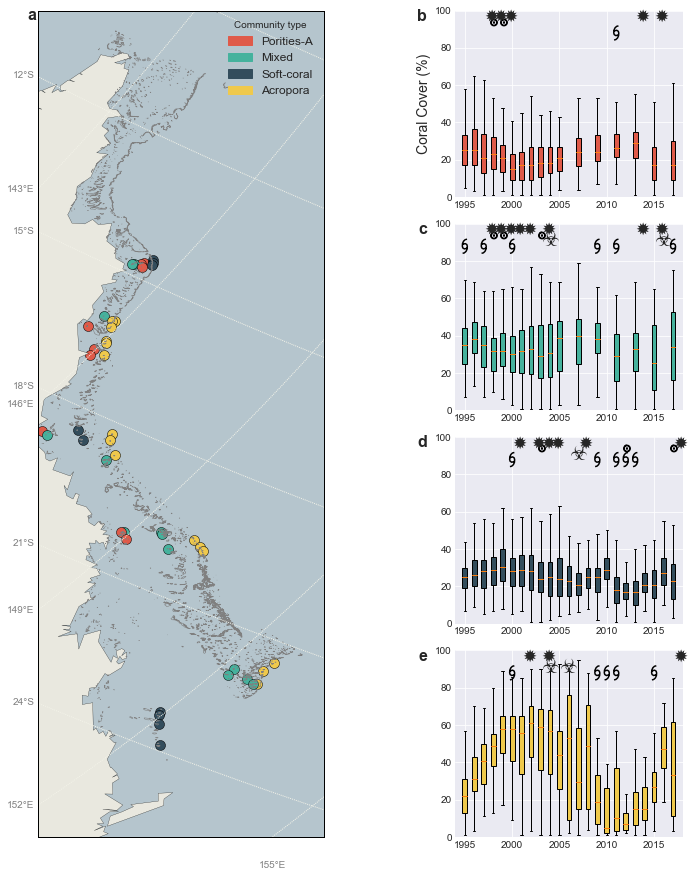

In [47]:
#"""
fig = plt.figure(figsize=(12, 12))

gs = mp.gridspec.GridSpec(4, 2, width_ratios=[3,1])
ax1 = fig.add_subplot(gs[:,0])

ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,1])
ax4 = fig.add_subplot(gs[2,1])
ax5 = fig.add_subplot(gs[3,1])



# = = = = = = = = = = = = = = = = = = = MAP = = = = = = = = = = = = = = = = = = = #
# Lat/longitudes
ymin, ymax = (-26.5,-8)
xmin, xmax = (153,145)
xmin = xmin-.5


# Map projection
mapx = bm(projection='rotpole',o_lat_p=132,o_lon_p=50,lon_0=0,llcrnrlat=ymin, llcrnrlon=xmin,urcrnrlon=xmax,urcrnrlat=ymax, resolution='l',ax=ax1)


# Draw map
mapx.drawmeridians(np.arange(110,190,3),labels=[1,0,0,1],fontsize=10,color='#f3f3e9', alpha=0.5)
mapx.drawparallels(np.arange(-30,17,3),labels=[1,0,0,0],fontsize=10,color='#f3f3e9', alpha=0.5)
mapx.drawcoastlines(linewidth=0.25)
mapx.drawcountries(linewidth=0.25)
mapx.drawmapboundary(fill_color='#b5c5cd')
mapx.fillcontinents(color='#e9e8df')

# Grab GBR shapefile
mapx.readshapefile('GBR_shapefiles/GBRMPA_reefs-dry_reefs', 'GBRMPA_reefs-dry_reefs',color='grey')
# Plot points
X,Y = mapx(xlon,xlat)
[mapx.scatter(x, y, c=c, s=100, edgecolor='black', linewidth='.5') for x,y,c in zip(X,Y,C)]

# Legend
#setting the legend for the plot using patch
CL1l = mpatches.Patch(color=xcol[0], label=Cluster[0])
CL12 = mpatches.Patch(color=xcol[1], label=Cluster[1])
CL13 = mpatches.Patch(color=xcol[2], label=Cluster[2])
CL14 = mpatches.Patch(color=xcol[3], label=Cluster[3])
ax1.legend(handles=[CL1l,CL12,CL13,CL14],title='Community type', loc=1, fontsize=12)
ax1.text(175.15, -40.2, 'a', fontsize=16, fontweight='bold', va='top', ha='right')


# = = = = = = = = = = = = = = = = = = = Cluster trends = = = = = = = = = = = = = = = = = = = #
xmin,xmax = 1994, 2018
ymin,ymax = 0,100
tx,ty = 1991, 101
yloc = 85
ifact = 3
isize = 60
hsize = 200
dsize = 20
csize = 17


i = 0
tmp_hc = HC[Ict==i]
tmp_yr = year[Ict==i]
sx,sy = ucombo(year[Ict==i],STORM_1[Ict==i])
bx,by = ucombo(year[Ict==i],BLEACH_1[Ict==i])
ux,uy = ucombo(year[Ict==i],DISEASE_1[Ict==i])
cx,cy = ucombo(year[Ict==i],CoTS_1[Ict==i])
tmp_u = UNK[Ict==i]
bp = ax2.boxplot([tmp_hc[tmp_yr==y] for y in np.unique(tmp_yr)],positions=np.unique(tmp_yr),patch_artist=True, showfliers=False)
for patch in bp['boxes']:
    patch.set_facecolor(xcol[i])
ax2.scatter(sx[sy>0],sy[sy>0]*yloc+ifact,edgecolors='black', facecolors='none',marker=hurricane,s=hsize, linewidth=1.5)
ax2.scatter(bx[by>0],by[by>0]*yloc+ifact*3,color='black',marker='$\odot$',s=isize)
[ax2.text(x,y*yloc+ifact*1,'$\u2623$', fontsize=dsize) for x,y in zip(ux[uy>0],uy[uy>0])]
[ax2.text(x,y*yloc+ifact*3,'$\u2739$', fontsize=csize) for x,y in zip(cx[cy>0],cy[cy>0])]

2739#ax2.scatter(tmp_yr[tmp_u==1],tmp_u[tmp_u==1]*yloc,color='black',marker='P',s=isize)
## Custom x-axis labels
ax2.set_xticks([1995,2000,2005,2010,2015])
ax2.set_xticklabels(['1995','2000','2005','2010','2015'])
ax2.text(tx, ty, 'b', fontsize=16, fontweight='bold', va='top', ha='right')
ax2.set_xlim(xmin,xmax)
ax2.set_ylim(ymin,ymax)
ax2.set_ylabel('Coral Cover (%)', fontsize=14)



i = 1
tmp_hc = HC[Ict==i]
tmp_yr = year[Ict==i]
sx,sy = ucombo(year[Ict==i],STORM_1[Ict==i])
bx,by = ucombo(year[Ict==i],BLEACH_1[Ict==i])
ux,uy = ucombo(year[Ict==i],DISEASE_1[Ict==i])
cx,cy = ucombo(year[Ict==i],CoTS_1[Ict==i])
tmp_u = UNK[Ict==i]
bp = ax3.boxplot([tmp_hc[tmp_yr==y] for y in np.unique(tmp_yr)],positions=np.unique(tmp_yr),patch_artist=True, showfliers=False)
for patch in bp['boxes']:
    patch.set_facecolor(xcol[i])
ax3.scatter(sx[sy>0],sy[sy>0]*yloc+ifact,edgecolors='black', facecolors='none',marker=hurricane,s=hsize, linewidth=1.5)
ax3.scatter(bx[by>0],by[by>0]*yloc+ifact*3,color='black',marker='$\odot$',s=isize)
[ax3.text(x,y*yloc+ifact*1,'$\u2623$', fontsize=dsize) for x,y in zip(ux[uy>0],uy[uy>0])]
[ax3.text(x,y*yloc+ifact*3,'$\u2739$', fontsize=csize) for x,y in zip(cx[cy>0],cy[cy>0])]

#ax3.scatter(tmp_yr[tmp_u==1],tmp_u[tmp_u==1]*yloc,color='black',edgecolor='black',marker='P',s=isize)
## Custom x-axis labels
ax3.set_xticks([1995,2000,2005,2010,2015])
ax3.set_xticklabels(['1995','2000','2005','2010','2015'])
ax3.text(tx, ty, 'c', fontsize=16, fontweight='bold', va='top', ha='right')
ax3.set_xlim(xmin,xmax)
ax3.set_ylim(ymin,ymax)


# SoftCoral
i = 3
tmp_hc = HC[Ict==i]
tmp_yr = year[Ict==i]
sx,sy = ucombo(year[Ict==i],STORM_1[Ict==i])
bx,by = ucombo(year[Ict==i],BLEACH_1[Ict==i])
ux,uy = ucombo(year[Ict==i],DISEASE_1[Ict==i])
cx,cy = ucombo(year[Ict==i],CoTS_1[Ict==i])
tmp_u = UNK[Ict==i]
bp = ax4.boxplot([tmp_hc[tmp_yr==y] for y in np.unique(tmp_yr)],positions=np.unique(tmp_yr),patch_artist=True, showfliers=False)
for patch in bp['boxes']:
    patch.set_facecolor(xcol[2])
ax4.scatter(sx[sy>0],sy[sy>0]*yloc+ifact,edgecolors='black', facecolors='none',marker=hurricane,s=hsize, linewidth=1.5)
ax4.scatter(bx[by>0],by[by>0]*yloc+ifact*3,color='black',marker='$\odot$',s=isize)
[ax4.text(x,y*yloc+ifact*1,'$\u2623$', fontsize=dsize) for x,y in zip(ux[uy>0],uy[uy>0])]
[ax4.text(x,y*yloc+ifact*3,'$\u2739$', fontsize=csize) for x,y in zip(cx[cy>0],cy[cy>0])]

#ax4.scatter(tmp_yr[tmp_u==1],tmp_u[tmp_u==1]*yloc,color='black',edgecolor='black',marker='P',s=isize)
## Custom x-axis labels
ax4.set_xticks([1995,2000,2005,2010,2015])
ax4.set_xticklabels(['1995','2000','2005','2010','2015'])
ax4.text(tx, ty, 'd', fontsize=16, fontweight='bold', va='top', ha='right')
ax4.set_xlim(xmin,xmax)
ax4.set_ylim(ymin,ymax)


# Acropora
i = 2
tmp_hc = HC[Ict==i]
tmp_yr = year[Ict==i]
sx,sy = ucombo(year[Ict==i],STORM_1[Ict==i])
bx,by = ucombo(year[Ict==i],BLEACH_1[Ict==i])
ux,uy = ucombo(year[Ict==i],DISEASE_1[Ict==i])
cx,cy = ucombo(year[Ict==i],CoTS_1[Ict==i])
tmp_u = UNK[Ict==i]
bp = ax5.boxplot([tmp_hc[tmp_yr==y] for y in np.unique(tmp_yr)],positions=np.unique(tmp_yr),patch_artist=True, showfliers=False)
for patch in bp['boxes']:
    patch.set_facecolor(xcol[3])
ax5.scatter(sx[sy>0],sy[sy>0]*yloc+ifact,edgecolors='black', facecolors='none',marker=hurricane,s=hsize, linewidth=1.5)
#ax5.text(bx[by>0],by[by>0]*yloc+ifact*3,'$\odot$', color='black',fontsize=isize)
[ax5.text(x,y*yloc+ifact*1,'$\u2623$', fontsize=dsize) for x,y in zip(ux[uy>0],uy[uy>0])]
[ax5.text(x,y*yloc+ifact*3,'$\u2739$', fontsize=csize) for x,y in zip(cx[cy>0],cy[cy>0])]
#ax5.scatter(tmp_yr[tmp_u==1],tmp_u[tmp_u==1]*yloc,color='black',edgecolor='black',marker='P',s=isize)
## Custom x-axis labels
ax5.set_xticks([1995,2000,2005,2010,2015])
ax5.set_xticklabels(['1995','2000','2005','2010','2015'])
ax5.text(tx, ty, 'e', fontsize=16, fontweight='bold', va='top', ha='right')
ax5.set_xlim(xmin,xmax)
ax5.set_ylim(ymin,ymax)
plt.tight_layout()

fig.savefig('Figure_1.pdf');

#""";

# Figure 2

In [48]:
# Average recovery curves from 10% coral cover
nyrs = 21
xyrs = np.linspace(0,nyrs,1)
curves = np.empty(shape=(ncluster,nyrs))
curves[:,0] = 10.
for i in range(ncluster):
    for y in range(1,nyrs):
        curves[i,y] = max(min(np.exp((np.median(r_Cluster.iloc[:,i])+np.median(beta_WQ)*muWQ[i])+(1.-np.median(a_Cluster.iloc[:,i]))*np.log(curves[i,y-1])),100),1)

In [49]:
list(beta_storms.columns.values)

['Storm_M', 'Storm_I', 'Storm_O']

In [50]:
parmas = [beta_zone, beta_herb, beta_WQ, beta_cots_wq, beta_bleach_wq, beta_disease_wq ,beta_cots_ca, beta_bleach_ca, beta_disease_ca]+[beta_cots[x].values for x in beta_cots]+[beta_Bleach, beta_Disease]+[beta_storms.iloc[:,i].values for i in range(3)]

parmlabels = ['Closed area (CA)', 'Herbivory','Water quality (PF$_C$)',"PF$_C\cdot$CoTS", "PF$_C\cdot$Bleaching", "PF$_C\cdot$Disease","CA$\cdot$CoTS", "CA$\cdot$Bleaching", "CA$\cdot$Disease"]+['CoTS ('+x[5:]+')' for x in beta_cots]+['Bleaching','Disease']+['Storm (Mid shelf)', 'Storm (Inner shelf)', 'Storm (Outer shelf)']

nparms = len(parmas)
nparms, len(parmlabels)

(18, 18)

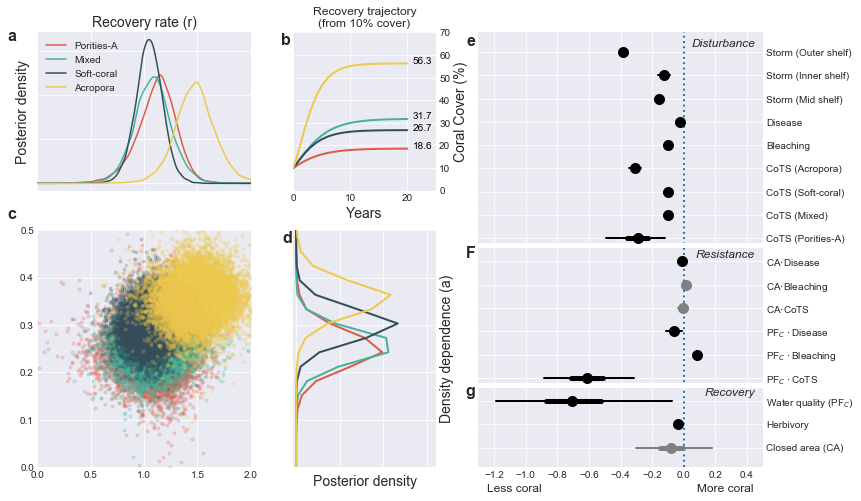

In [51]:
fig = plt.figure(figsize=(13, 8))

gs = mp.gridspec.GridSpec(2, 3, width_ratios=[1.5,1,2], height_ratios=[1,1.5])
ax2 = plt.subplot(gs[0,0])
ax3 = plt.subplot(gs[1,1])
ax1 = plt.subplot(gs[0,1])
ax4 = plt.subplot(gs[1,0])
ax5 = plt.subplot(gs[:,2])


# Plot recovery from 10% coral cover
[ax1.plot(range(nyrs),curves[i],c=xcol[i],linewidth=2) for i in range(ncluster)]
[ax1.text(21,max(curves[i]),str(round(max(curves[i]),1)),color='black') for i in range(ncluster)]
ax1.set_xlim(0,25)
ax1.set_ylim(0,70)
ax1.yaxis.tick_right()
ax1.set_ylabel('Coral Cover (%)', fontsize=14)
ax1.yaxis.set_label_position("right")
ax1.set_xlabel('Years', fontsize=14)
ax1.set_title('Recovery trajectory\n(from 10% cover)')
ax1.text(-0.5, 70, 'b', fontsize=16, fontweight='bold', va='top', ha='right')



# Joint scatter
[ax4.plot(r_Cluster.iloc[:,i],a_Cluster.iloc[:,i],'.',c=xcol[i],alpha=0.2) for i in range(ncluster)]
ax4.set_xlim(0,2)
ax4.set_ylim(0,.5)
ax4.set_xlabel('')
ax4.set_ylabel('')
ax4.text(-0.2, .55, 'c', fontsize=16, fontweight='bold', va='top', ha='right')

# R results
r_Cluster.plot(kind='kde', xlim=(0,2.5), color=xcol, ax=ax2)
ax2.set_xlim(0,2)
ax2.set_xticklabels('')
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_yticklabels('')
ax2.set_ylabel('Posterior density', fontsize=14)
ax2.set_title('Recovery rate (r)', fontsize=14)
ax2.text(-0.2, 3.5, 'a', fontsize=16, fontweight='bold', va='top', ha='right')


# a retults
ydens = [gaussian_kde(a_Cluster.iloc[:,i]) for i in range(ncluster)]
xnew = np.linspace(0,3,100)

[ax3.plot(ydens[i](xnew),xnew,color=xcol[i], linewidth=2) for i in range(ncluster)]
ax3.set_ylim(0,.5)
ax3.set_xlim(-0.3,16)
ax3.set_yticklabels('')
ax3.set_xticklabels('')
ax3.yaxis.set_label_position("right")
ax3.set_ylabel('Density dependence (a)', fontsize=14)
ax3.set_xlabel('Posterior density', fontsize=14)
ax3.text(-0.5, .5, 'd', fontsize=16, fontweight='bold', va='top', ha='right')


xmin,xmax = -1.3, .5
ax5.axvline(x=0, linestyle=':', linewidth=2)
ax5.yaxis.tick_right()
ax5.set_yticks(range(nparms))
#ax5.set_xlabel('Effect size', fontsize=14)
ax5.set_xlabel('Less coral                                              More coral', fontsize=12)
ax5.yaxis.set_label_position("right")
ax5.set_yticklabels(parmlabels)
ax5.text(xmax-.05, nparms-.4, 'Disturbance', fontsize=12, style='italic', fontweight='medium', va='top', ha='right')
ax5.text(-1.32, nparms-.2, 'e', fontsize=16, fontweight='bold', va='top', ha='right')
ax5.plot((xmin,xmax),(8.7,8.7),c="white",linewidth=5)
ax5.text(xmax-.05, 8.5, 'Resistance', fontsize=12, style='italic', fontweight='medium', va='top', ha='right')
ax5.text(-1.32, 8.5+.2, 'F', fontsize=16, fontweight='bold', va='top', ha='right')
ax5.text(xmax-.05, 2.56, 'Recovery', fontsize=12, style='italic', fontweight='medium', va='top', ha='right')
ax5.plot((xmin,xmax),(2.7,2.7),c="white",linewidth=5)
ax5.text(-1.32, 2.56+.2, 'g', fontsize=16, fontweight='bold', va='top', ha='right')
[gelplot(ax5,parmas[i],i,csize=20,lwd50=5,lwd95=2) for i in range(nparms)]


ax5.set_xlim(xmin,xmax)

#fig.tight_layout(pad=1)

fig.savefig('Figure_2.pdf');

# Figure 3

In [52]:
# Grab dimensions
nsim = np.shape(HC_projection_wq)[1]
nyrs = np.shape(HC_projection_wq)[2]
nlin = np.shape(HC_projection_wq)[0]

In [53]:
np.percentile(HC_projection_wq_b1[5].T[0][nyrs-1],97.5)-np.percentile(HC_projection_wq[0].T[0][nyrs-1],97.5)

0.0

In [54]:
np.percentile(HC_projection_wq_b1[5].T[0][nyrs-1]-HC_projection_wq[5].T[0][nyrs-1],97.5)

1.4291521984114746

In [55]:
np.percentile(np.sort(HC_projection_wq_b1[5].T[0][nyrs-1])-np.sort(HC_projection_wq[5].T[0][nyrs-1]),2.5)

-6.069259379557753

In [56]:
# Calculate expected hard coral cover given projected improvements in water quality
HC_Porities_wq = np.array([np.percentile(HC_projection_wq[z].T[0],50,1) for z in range(nlin)])
HC_Mixed_wq = np.array([np.percentile(HC_projection_wq[z].T[1],50,1) for z in range(nlin)])
HC_Acropora_wq = np.array([np.percentile(HC_projection_wq[z].T[3],50,1) for z in range(nlin)])
HC_SoftCoral_wq = np.array([np.percentile(HC_projection_wq[z].T[2],50,1) for z in range(nlin)])
HC_wq = [HC_Porities_wq, HC_Mixed_wq, HC_SoftCoral_wq, HC_Acropora_wq]


# Calculate expected hard coral cover given projected improvements in water quality
HC_Porities_wq_l95 = np.array([np.percentile(HC_projection_wq[z].T[0],2.5,1) for z in range(nlin)])
HC_Mixed_wq_l95 = np.array([np.percentile(HC_projection_wq[z].T[1],2.5,1) for z in range(nlin)])
HC_Acropora_wq_l95 = np.array([np.percentile(HC_projection_wq[z].T[3],2.5,1) for z in range(nlin)])
HC_SoftCoral_wq_l95 = np.array([np.percentile(HC_projection_wq[z].T[2],2.5,1) for z in range(nlin)])
HC_wq_l95 = [HC_Porities_wq_l95, HC_Mixed_wq_l95, HC_SoftCoral_wq_l95, HC_Acropora_wq_l95]

# Calculate expected hard coral cover given projected improvements in water quality
HC_Porities_wq_u95 = np.array([np.percentile(HC_projection_wq[z].T[0],97.5,1) for z in range(nlin)])
HC_Mixed_wq_u95 = np.array([np.percentile(HC_projection_wq[z].T[1],97.5,1) for z in range(nlin)])
HC_Acropora_wq_u95 = np.array([np.percentile(HC_projection_wq[z].T[3],97.5,1) for z in range(nlin)])
HC_SoftCoral_wq_u95 = np.array([np.percentile(HC_projection_wq[z].T[2],97.5,1) for z in range(nlin)])
HC_wq_u95 = [HC_Porities_wq_u95, HC_Mixed_wq_u95, HC_SoftCoral_wq_u95, HC_Acropora_wq_u95]


# Calculate expected hard coral cover given projected improvements in water quality
HC_Porities_wq_l50 = np.array([np.percentile(HC_projection_wq[z].T[0],25,1) for z in range(nlin)])
HC_Mixed_wq_l50 = np.array([np.percentile(HC_projection_wq[z].T[1],25,1) for z in range(nlin)])
HC_Acropora_wq_l50 = np.array([np.percentile(HC_projection_wq[z].T[3],25,1) for z in range(nlin)])
HC_SoftCoral_wq_l50 = np.array([np.percentile(HC_projection_wq[z].T[2],25,1) for z in range(nlin)])
HC_wq_l50 = [HC_Porities_wq_l50, HC_Mixed_wq_l50, HC_SoftCoral_wq_l50, HC_Acropora_wq_l50]

# Calculate expected hard coral cover given projected improvements in water quality
HC_Porities_wq_u50 = np.array([np.percentile(HC_projection_wq[z].T[0],75,1) for z in range(nlin)])
HC_Mixed_wq_u50 = np.array([np.percentile(HC_projection_wq[z].T[1],75,1) for z in range(nlin)])
HC_Acropora_wq_u50 = np.array([np.percentile(HC_projection_wq[z].T[3],75,1) for z in range(nlin)])
HC_SoftCoral_wq_u50 = np.array([np.percentile(HC_projection_wq[z].T[2],75,1) for z in range(nlin)])
HC_wq_u50 = [HC_Porities_wq_u50, HC_Mixed_wq_u50, HC_SoftCoral_wq_u50, HC_Acropora_wq_u50]


In [57]:
np.percentile(HC_projection_wq_b1[0].T[0],2.5,1)

array([21.        , 10.01954408,  8.54958393,  8.03803955,  7.23514594,
        6.46628652,  6.20368011,  6.60514766,  6.39626765,  6.53011964,
        6.32927351,  6.50120653,  6.05587597,  5.84763324,  6.11446657,
        6.53528746,  6.08512859,  6.07420685,  6.51441935,  6.31975507,
        6.36317946,  6.09082019,  6.09119519,  6.31768374,  6.23221912,
        5.95394387,  5.88798391,  5.87385909,  6.0761266 ,  6.03106756,
        6.43863026,  6.00714759,  5.63246787,  5.51961312,  5.8022581 ])

In [58]:
# Calculate expected hard coral cover given projected improvements in water quality under S1
HC_Porities_wq_b1 = np.array([np.percentile(HC_projection_wq_b1[z].T[0],50,1) for z in range(nlin)])
HC_Mixed_wq_b1 = np.array([np.percentile(HC_projection_wq_b1[z].T[1],50,1) for z in range(nlin)])
HC_Acropora_wq_b1 = np.array([np.percentile(HC_projection_wq_b1[z].T[3],50,1) for z in range(nlin)])
HC_SoftCoral_wq_b1 = np.array([np.percentile(HC_projection_wq_b1[z].T[2],50,1) for z in range(nlin)])
HC_wq_b1 = [HC_Porities_wq_b1, HC_Mixed_wq_b1, HC_SoftCoral_wq_b1, HC_Acropora_wq_b1]

# Calculate expected hard coral cover given projected improvements in water quality under S1
HC_Porities_wq_b1_l95 = np.array([np.percentile(HC_projection_wq_b1[z].T[0],2.5,1) for z in range(nlin)])
HC_Mixed_wq_b1_l95 = np.array([np.percentile(HC_projection_wq_b1[z].T[1],2.5,1) for z in range(nlin)])
HC_Acropora_wq_b1_l95 = np.array([np.percentile(HC_projection_wq_b1[z].T[3],2.5,1) for z in range(nlin)])
HC_SoftCoral_wq_b1_l95 = np.array([np.percentile(HC_projection_wq_b1[z].T[2],2.5,1) for z in range(nlin)])
HC_wq_b1_l95 = [HC_Porities_wq_b1_l95, HC_Mixed_wq_b1_l95, HC_SoftCoral_wq_b1_l95, HC_Acropora_wq_b1_l95]

# Calculate expected hard coral cover given projected improvements in water quality under S1
HC_Porities_wq_b1_l50 = np.array([np.percentile(HC_projection_wq_b1[z].T[0],25,1) for z in range(nlin)])
HC_Mixed_wq_b1_l50 = np.array([np.percentile(HC_projection_wq_b1[z].T[1],25,1) for z in range(nlin)])
HC_Acropora_wq_b1_l50 = np.array([np.percentile(HC_projection_wq_b1[z].T[3],25,1) for z in range(nlin)])
HC_SoftCoral_wq_b1_l50 = np.array([np.percentile(HC_projection_wq_b1[z].T[2],25,1) for z in range(nlin)])
HC_wq_b1_l50 = [HC_Porities_wq_b1_l50, HC_Mixed_wq_b1_l50, HC_SoftCoral_wq_b1_l50, HC_Acropora_wq_b1_l50]

# Calculate expected hard coral cover given projected improvements in water quality under S1
HC_Porities_wq_b1_u50 = np.array([np.percentile(HC_projection_wq_b1[z].T[0],75,1) for z in range(nlin)])
HC_Mixed_wq_b1_u50 = np.array([np.percentile(HC_projection_wq_b1[z].T[1],75,1) for z in range(nlin)])
HC_Acropora_wq_b1_u50 = np.array([np.percentile(HC_projection_wq_b1[z].T[3],75,1) for z in range(nlin)])
HC_SoftCoral_wq_b1_u50 = np.array([np.percentile(HC_projection_wq_b1[z].T[2],75,1) for z in range(nlin)])
HC_wq_b1_u50 = [HC_Porities_wq_b1_u50, HC_Mixed_wq_b1_u50, HC_SoftCoral_wq_b1_u50, HC_Acropora_wq_b1_u50]

# Calculate expected hard coral cover given projected improvements in water quality under S1
HC_Porities_wq_b1_u95 = np.array([np.percentile(HC_projection_wq_b1[z].T[0],97.5,1) for z in range(nlin)])
HC_Mixed_wq_b1_u95 = np.array([np.percentile(HC_projection_wq_b1[z].T[1],97.5,1) for z in range(nlin)])
HC_Acropora_wq_b1_u95 = np.array([np.percentile(HC_projection_wq_b1[z].T[3],97.5,1) for z in range(nlin)])
HC_SoftCoral_wq_b1_u95 = np.array([np.percentile(HC_projection_wq_b1[z].T[2],97.5,1) for z in range(nlin)])
HC_wq_b1_u95 = [HC_Porities_wq_b1_u95, HC_Mixed_wq_b1_u95, HC_SoftCoral_wq_b1_u95, HC_Acropora_wq_b1_u95]

In [59]:
# Calculate expected hard coral cover given projected improvements in water quality under S2
HC_Porities_wq_b2 = np.array([np.percentile(HC_projection_wq_b2[z].T[0],50,1) for z in range(nlin)])
HC_Mixed_wq_b2 = np.array([np.percentile(HC_projection_wq_b2[z].T[1],50,1) for z in range(nlin)])
HC_Acropora_wq_b2 = np.array([np.percentile(HC_projection_wq_b2[z].T[3],50,1) for z in range(nlin)])
HC_SoftCoral_wq_b2 = np.array([np.percentile(HC_projection_wq_b2[z].T[2],50,1) for z in range(nlin)])
HC_wq_b2 = [HC_Porities_wq_b2, HC_Mixed_wq_b2,HC_SoftCoral_wq_b2, HC_Acropora_wq_b2]

# Calculate expected hard coral cover given projected improvements in water quality under S2
HC_Porities_wq_b2_l95 = np.array([np.percentile(HC_projection_wq_b2[z].T[0],2.5,1) for z in range(nlin)])
HC_Mixed_wq_b2_l95 = np.array([np.percentile(HC_projection_wq_b2[z].T[1],2.5,1) for z in range(nlin)])
HC_Acropora_wq_b2_l95 = np.array([np.percentile(HC_projection_wq_b2[z].T[3],2.5,1) for z in range(nlin)])
HC_SoftCoral_wq_b2_l95 = np.array([np.percentile(HC_projection_wq_b2[z].T[2],2.5,1) for z in range(nlin)])
HC_wq_b2_l95 = [HC_Porities_wq_b2_l95, HC_Mixed_wq_b2_l95, HC_SoftCoral_wq_b2_l95, HC_Acropora_wq_b2_l95]

# Calculate expected hard coral cover given projected improvements in water quality under S2
HC_Porities_wq_b2_l50 = np.array([np.percentile(HC_projection_wq_b2[z].T[0],25,1) for z in range(nlin)])
HC_Mixed_wq_b2_l50 = np.array([np.percentile(HC_projection_wq_b2[z].T[1],25,1) for z in range(nlin)])
HC_Acropora_wq_b2_l50 = np.array([np.percentile(HC_projection_wq_b2[z].T[3],25,1) for z in range(nlin)])
HC_SoftCoral_wq_b2_l50 = np.array([np.percentile(HC_projection_wq_b2[z].T[2],25,1) for z in range(nlin)])
HC_wq_b2_l50 = [HC_Porities_wq_b2_l50, HC_Mixed_wq_b2_l50, HC_SoftCoral_wq_b2_l50, HC_Acropora_wq_b2_l50]

# Calculate expected hard coral cover given projected improvements in water quality under S2
HC_Porities_wq_b2_u50 = np.array([np.percentile(HC_projection_wq_b2[z].T[0],75,1) for z in range(nlin)])
HC_Mixed_wq_b2_u50 = np.array([np.percentile(HC_projection_wq_b2[z].T[1],75,1) for z in range(nlin)])
HC_Acropora_wq_b2_u50 = np.array([np.percentile(HC_projection_wq_b2[z].T[3],75,1) for z in range(nlin)])
HC_SoftCoral_wq_b2_u50 = np.array([np.percentile(HC_projection_wq_b2[z].T[2],75,1) for z in range(nlin)])
HC_wq_b2_u50 = [HC_Porities_wq_b2_u50, HC_Mixed_wq_b2_u50, HC_SoftCoral_wq_b2_u50, HC_Acropora_wq_b2_u50]

# Calculate expected hard coral cover given projected improvements in water quality under S2
HC_Porities_wq_b2_u95 = np.array([np.percentile(HC_projection_wq_b2[z].T[0],97.5,1) for z in range(nlin)])
HC_Mixed_wq_b2_u95 = np.array([np.percentile(HC_projection_wq_b2[z].T[1],97.5,1) for z in range(nlin)])
HC_Acropora_wq_b2_u95 = np.array([np.percentile(HC_projection_wq_b2[z].T[3],97.5,1) for z in range(nlin)])
HC_SoftCoral_wq_b2_u95 = np.array([np.percentile(HC_projection_wq_b2[z].T[2],97.5,1) for z in range(nlin)])
HC_wq_b2_u95 = [HC_Porities_wq_b2_u95, HC_Mixed_wq_b2_u95, HC_SoftCoral_wq_b2_u95, HC_Acropora_wq_b2_u95]


In [60]:
# Calculate expected hard coral cover given projected improvements in water quality under S3
HC_Porities_wq_b3 = np.array([np.percentile(HC_projection_wq_b3[z].T[0],50,1) for z in range(nlin)])
HC_Mixed_wq_b3 = np.array([np.percentile(HC_projection_wq_b3[z].T[1],50,1) for z in range(nlin)])
HC_Acropora_wq_b3 = np.array([np.percentile(HC_projection_wq_b3[z].T[3],50,1) for z in range(nlin)])
HC_SoftCoral_wq_b3 = np.array([np.percentile(HC_projection_wq_b3[z].T[2],50,1) for z in range(nlin)])
HC_wq_b3 = [HC_Porities_wq_b3, HC_Mixed_wq_b3, HC_SoftCoral_wq_b3, HC_Acropora_wq_b3]


# Calculate expected hard coral cover given projected improvements in water quality under S3
HC_Porities_wq_b3_l95 = np.array([np.percentile(HC_projection_wq_b3[z].T[0],2.5,1) for z in range(nlin)])
HC_Mixed_wq_b3_l95 = np.array([np.percentile(HC_projection_wq_b3[z].T[1],2.5,1) for z in range(nlin)])
HC_Acropora_wq_b3_l95 = np.array([np.percentile(HC_projection_wq_b3[z].T[3],2.5,1) for z in range(nlin)])
HC_SoftCoral_wq_b3_l95 = np.array([np.percentile(HC_projection_wq_b3[z].T[2],2.5,1) for z in range(nlin)])
HC_wq_b3_l95 = [HC_Porities_wq_b3_l95, HC_Mixed_wq_b3_l95, HC_SoftCoral_wq_b3_l95, HC_Acropora_wq_b3_l95]

# Calculate expected hard coral cover given projected improvements in water quality under S3
HC_Porities_wq_b3_l50 = np.array([np.percentile(HC_projection_wq_b3[z].T[0],25,1) for z in range(nlin)])
HC_Mixed_wq_b3_l50 = np.array([np.percentile(HC_projection_wq_b3[z].T[1],25,1) for z in range(nlin)])
HC_Acropora_wq_b3_l50 = np.array([np.percentile(HC_projection_wq_b3[z].T[3],25,1) for z in range(nlin)])
HC_SoftCoral_wq_b3_l50 = np.array([np.percentile(HC_projection_wq_b3[z].T[2],25,1) for z in range(nlin)])
HC_wq_b3_l50 = [HC_Porities_wq_b3_l50, HC_Mixed_wq_b3_l50, HC_SoftCoral_wq_b3_l50, HC_Acropora_wq_b3_l50]

# Calculate expected hard coral cover given projected improvements in water quality under S3
HC_Porities_wq_b3_u50 = np.array([np.percentile(HC_projection_wq_b3[z].T[0],75,1) for z in range(nlin)])
HC_Mixed_wq_b3_u50 = np.array([np.percentile(HC_projection_wq_b3[z].T[1],75,1) for z in range(nlin)])
HC_Acropora_wq_b3_u50 = np.array([np.percentile(HC_projection_wq_b3[z].T[3],75,1) for z in range(nlin)])
HC_SoftCoral_wq_b3_u50 = np.array([np.percentile(HC_projection_wq_b3[z].T[2],75,1) for z in range(nlin)])
HC_wq_b3_u50 = [HC_Porities_wq_b3_u50, HC_Mixed_wq_b3_u50, HC_SoftCoral_wq_b3_u50, HC_Acropora_wq_b3_u50]

# Calculate expected hard coral cover given projected improvements in water quality under S3
HC_Porities_wq_b3_u95 = np.array([np.percentile(HC_projection_wq_b3[z].T[0],97.5,1) for z in range(nlin)])
HC_Mixed_wq_b3_u95 = np.array([np.percentile(HC_projection_wq_b3[z].T[1],97.5,1) for z in range(nlin)])
HC_Acropora_wq_b3_u95 = np.array([np.percentile(HC_projection_wq_b3[z].T[3],97.5,1) for z in range(nlin)])
HC_SoftCoral_wq_b3_u95 = np.array([np.percentile(HC_projection_wq_b3[z].T[2],97.5,1) for z in range(nlin)])
HC_wq_b3_u95 = [HC_Porities_wq_b3_u95, HC_Mixed_wq_b3_u95, HC_SoftCoral_wq_b3_u95, HC_Acropora_wq_b3_u95]

In [61]:
# Calculate expected hard coral cover given projected improvements in water quality under S4
HC_Porities_wq_b4 = np.array([np.percentile(HC_projection_wq_b4[z].T[0],50,1) for z in range(nlin)])
HC_Mixed_wq_b4 = np.array([np.percentile(HC_projection_wq_b4[z].T[1],50,1) for z in range(nlin)])
HC_Acropora_wq_b4 = np.array([np.percentile(HC_projection_wq_b4[z].T[3],50,1) for z in range(nlin)])
HC_SoftCoral_wq_b4 = np.array([np.percentile(HC_projection_wq_b4[z].T[2],50,1) for z in range(nlin)])
HC_wq_b4 = [HC_Porities_wq_b4, HC_Mixed_wq_b4, HC_SoftCoral_wq_b4, HC_Acropora_wq_b4]


# Calculate expected hard coral cover given projected improvements in water quality under S4
HC_Porities_wq_b4_l95 = np.array([np.percentile(HC_projection_wq_b4[z].T[0],2.5,1) for z in range(nlin)])
HC_Mixed_wq_b4_l95 = np.array([np.percentile(HC_projection_wq_b4[z].T[1],2.5,1) for z in range(nlin)])
HC_Acropora_wq_b4_l95 = np.array([np.percentile(HC_projection_wq_b4[z].T[3],2.5,1) for z in range(nlin)])
HC_SoftCoral_wq_b4_l95 = np.array([np.percentile(HC_projection_wq_b4[z].T[2],2.5,1) for z in range(nlin)])
HC_wq_b4_l95 = [HC_Porities_wq_b4_l95, HC_Mixed_wq_b4_l95, HC_SoftCoral_wq_b4_l95, HC_Acropora_wq_b4_l95]

# Calculate expected hard coral cover given projected improvements in water quality under S4
HC_Porities_wq_b4_l50 = np.array([np.percentile(HC_projection_wq_b4[z].T[0],25,1) for z in range(nlin)])
HC_Mixed_wq_b4_l50 = np.array([np.percentile(HC_projection_wq_b4[z].T[1],25,1) for z in range(nlin)])
HC_Acropora_wq_b4_l50 = np.array([np.percentile(HC_projection_wq_b4[z].T[3],25,1) for z in range(nlin)])
HC_SoftCoral_wq_b4_l50 = np.array([np.percentile(HC_projection_wq_b4[z].T[2],25,1) for z in range(nlin)])
HC_wq_b4_l50 = [HC_Porities_wq_b4_l50, HC_Mixed_wq_b4_l50, HC_SoftCoral_wq_b4_l50, HC_Acropora_wq_b4_l50]

# Calculate expected hard coral cover given projected improvements in water quality under S4
HC_Porities_wq_b4_u50 = np.array([np.percentile(HC_projection_wq_b4[z].T[0],75,1) for z in range(nlin)])
HC_Mixed_wq_b4_u50 = np.array([np.percentile(HC_projection_wq_b4[z].T[1],75,1) for z in range(nlin)])
HC_Acropora_wq_b4_u50 = np.array([np.percentile(HC_projection_wq_b4[z].T[3],75,1) for z in range(nlin)])
HC_SoftCoral_wq_b4_u50 = np.array([np.percentile(HC_projection_wq_b4[z].T[2],75,1) for z in range(nlin)])
HC_wq_b4_u50 = [HC_Porities_wq_b4_u50, HC_Mixed_wq_b4_u50, HC_SoftCoral_wq_b4_u50, HC_Acropora_wq_b4_u50]

# Calculate expected hard coral cover given projected improvements in water quality under S4
HC_Porities_wq_b4_u95 = np.array([np.percentile(HC_projection_wq_b4[z].T[0],97.5,1) for z in range(nlin)])
HC_Mixed_wq_b4_u95 = np.array([np.percentile(HC_projection_wq_b4[z].T[1],97.5,1) for z in range(nlin)])
HC_Acropora_wq_b4_u95 = np.array([np.percentile(HC_projection_wq_b4[z].T[3],97.5,1) for z in range(nlin)])
HC_SoftCoral_wq_b4_u95 = np.array([np.percentile(HC_projection_wq_b4[z].T[2],97.5,1) for z in range(nlin)])
HC_wq_b4_u95 = [HC_Porities_wq_b4_u95, HC_Mixed_wq_b4_u95, HC_SoftCoral_wq_b4_u95, HC_Acropora_wq_b4_u95]

In [62]:
# Expected hard coral benefit of improved water quality over status quo
WQ_Porities = np.array([np.percentile(WQ_projection[z].T[0],50,1) for z in range(nlin)])
WQ_Mixed = np.array([np.percentile(WQ_projection[z].T[1],50,1) for z in range(nlin)])
WQ_Acropora = np.array([np.percentile(WQ_projection[z].T[3],50,1) for z in range(nlin)])
WQ_SoftCoral = np.array([np.percentile(WQ_projection[z].T[2],50,1) for z in range(nlin)])


# Calculate expected hard coral benefit given projected improvements in water quality under S1
WQ_Porities_b1 = np.array([np.percentile(WQ_projection_b1[z].T[0],50,1) for z in range(nlin)])
WQ_Mixed_b1 = np.array([np.percentile(WQ_projection_b1[z].T[1],50,1) for z in range(nlin)])
WQ_Acropora_b1 = np.array([np.percentile(WQ_projection_b1[z].T[3],50,1) for z in range(nlin)])
WQ_SoftCoral_b1 = np.array([np.percentile(WQ_projection_b1[z].T[2],50,1) for z in range(nlin)])

In [63]:
# Import data
S1data = pd.read_csv('no_adaptation.csv',names=['Year','PB'])
S2data = pd.read_csv('80_yr_window.csv',names=['Year','PB'])
S3data = pd.read_csv('hughes_proj.csv')
S4data = pd.read_csv('Max_DHW_per_year_GBR.csv')

In [64]:
S4data['PB'] = S4data.AverageDHW.values/8

In [65]:
# Tidy up scenario data and make continuous

# Years to fit
xnew_yr = np.linspace(2018, 2055, num=40, endpoint=True)

# Get smoothing functions
fS1 = interp1d(S1data.Year, S1data.PB, kind='cubic')
fS2 = interp1d(S2data.Year, S2data.PB, kind='cubic')
#fS3 = interp1d(S3data.Year, S3data.PB, kind='cubic')
fS4 = interp1d(S4data.Year, S4data.PB, kind='cubic')

# Calculate fits
S1proj = fS1(xnew_yr)/100
S2proj = fS2(xnew_yr)/100
S3proj = S3data.PB.values[S3data.Year.values>2014]
S4proj = fS4(xnew_yr)/100

# Ratio projections
S1pr = S1proj/S1proj[0]
S2pr = S2proj/S2proj[0]
S3pr = S3proj/S3proj[0]
S4pr = S4proj/S4proj[0]

In [66]:
npercx = nlin
mymap = plt.get_cmap("Greens")
my_colors = mymap(np.arange(npercx)/npercx)

In [67]:
def Lndx(Listx,xval):
    return min(range(len(Listx)), key=lambda i: abs(Listx[i]-xval))

In [68]:
# Max HC per cluster
maxhc = np.array([round(max(curves[list(r_Cluster.columns).index(x)]),1) for x in r_Cluster.columns])

In [69]:
# Initial 2017 reef-averaged cover
HC_2017_r = []
for i in range(nreefs):
    tmp = xdata.iloc[Ir==i]
    HC_2017_r += [np.mean(tmp.HC.values[tmp.REPORT_YEAR.values==max(tmp.REPORT_YEAR.values)])]

# Initial 2017 cluster-averaged cover
HC_2017 = np.array([np.mean(np.array(HC_2017_r)[Ic==i]) for i in range(ncluster)])

/Users/aaronmacneil/anaconda/lib/python3.6/site-packages/matplotlib/legend.py:1364: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  warnings.warn("You have mixed positional and keyword "


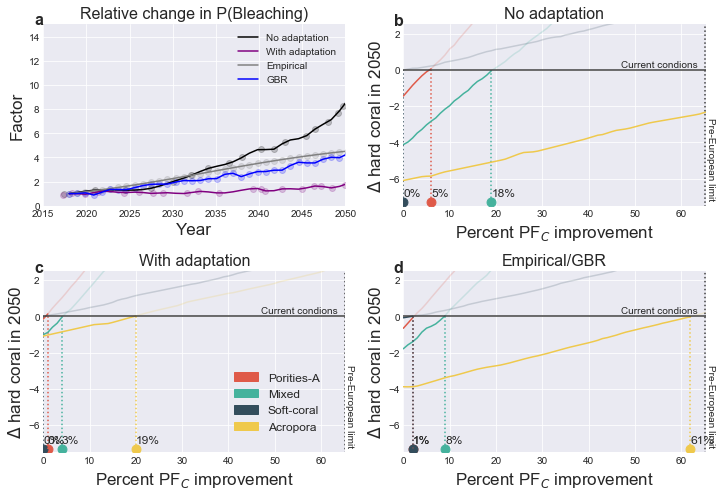

In [70]:
fig = plt.figure(figsize=(10, 7))

gs = mp.gridspec.GridSpec(2, 2)
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[1,0])
ax4 = plt.subplot(gs[1,1])

# Text
axfont = 17
#setting the legend for the plot using patch
CL1l = mpatches.Patch(color=xcol[0], label=Cluster[0])
CL12 = mpatches.Patch(color=xcol[1], label=Cluster[1])
CL13 = mpatches.Patch(color=xcol[2], label=Cluster[2])
CL14 = mpatches.Patch(color=xcol[3], label=Cluster[3])
# Parms
ccx = 47
offx = 0.5
offy = .1


# Plot bleaching scenarios
# Plot smoothed scenario data 
ax1.scatter(S1data.Year,S1data.PB/100/S1proj[0],alpha=.2, c='black')
line1 = ax1.plot(xnew_yr, S1pr, label='No adaptation', c='black')
ax1.scatter(S2data.Year,S2data.PB/100/S2proj[0],alpha=.2, c='purple')
line2 = ax1.plot(xnew_yr, S2pr, label='With adaptation', c='purple')
ax1.scatter(xnew_yr,S3proj/S3proj[0], label='Hughes et al.',alpha=.2, c='grey')
line3 = ax1.plot(xnew_yr, S3pr, c='grey')
ax1.scatter(xnew_yr,S4proj/S4proj[0], label='van Hooidonk et al.',alpha=.2, c='blue')
line4 = ax1.plot(xnew_yr, S4pr, c='blue')

ax1.set_xlabel('Year',fontsize=axfont)
ax1.set_ylabel('Factor',fontsize=axfont)
ax1.set_xlim(2015,2050)
ax1.set_ylim(0,15)
ax1.set_title('Relative change in P(Bleaching)',fontsize=axfont-1)
ax1.text(2015, 16, 'a', fontsize=16, fontweight='bold', va='top', ha='right')
ax1.legend((line1,line2,line3,line4),labels=('No adaptation','With adaptation','Empirical','GBR'))


# No adaptation
ymin = -7.5
nrecs = nlin
for i in range(ncluster):
    xnew = range(nrecs)
    #ynew = (HC_wq_b1[i].T[nyrs-1]-max(HC_wq[i][0]))
    ynew = (HC_wq_b1[i].T[nyrs-1]-HC_wq[i][0][nyrs-1])
    tmp = Lndx(ynew,0)
    ax2.scatter(xnew[tmp],ymin+.2,s=79,c=xcol[i])
    ax2.plot([xnew[tmp]]*2,(ymin+.2,0),c=xcol[i],linestyle=":")
    ax2.plot(xnew[:tmp+1],ynew[:tmp+1],color=xcol[i])
    ax2.plot(xnew[tmp:],ynew[tmp:],alpha=0.2,color=xcol[i])
    if xnew[tmp]<1:
        ax2.text(xnew[tmp],ymin+offx,'0'+'%',fontsize=12)
    elif xnew[tmp]<max_PFx:
        ax2.text(xnew[tmp],ymin+offx,str(xnew[tmp-1])+'%',fontsize=12)

ax2.text(ccx,0.15,'Current condions')
ax2.set_xlabel('Percent PF$_{C}$ improvement', fontsize=axfont)
ax2.set_ylabel('$\Delta$ hard coral in 2050', fontsize=axfont)
ax2.plot((-100,100),(0,0),c='0.25')
ax2.set_ylim(ymin,2.5)
ax2.set_xlim(0,max_PFx+offy)
ax2.set_title('No adaptation',fontsize=axfont-1)
ax2.text(0, 3.1, 'b', fontsize=16, fontweight='bold', va='top', ha='right')
ax2.plot((max_PFx,max_PFx),(-100,100),c='0.25',linestyle=":")
ax2.text(max_PFx+offy,-3,'Pre-European limit',rotation=-90)


# Rolling window
for i in range(ncluster):
    xnew = range(nrecs)
    ynew = (HC_wq_b2[i].T[nyrs-1]-HC_wq[i][0][nyrs-1])
    tmp = Lndx(ynew,0)
    ax3.scatter(xnew[tmp],ymin+.2,s=79,c=xcol[i])
    ax3.plot([xnew[tmp]]*2,(ymin+.2,0),c=xcol[i],linestyle=":")
    ax3.plot(xnew[:tmp+1],ynew[:tmp+1],color=xcol[i])
    ax3.plot(xnew[tmp:],ynew[tmp:],alpha=0.2,color=xcol[i])
    if xnew[tmp]<1:
        ax3.text(xnew[tmp],ymin+offx,'0'+'%',fontsize=12)
    elif xnew[tmp]<max_PFx:
        ax3.text(xnew[tmp],ymin+offx,str(xnew[tmp-1])+'%',fontsize=12)

ax3.legend(handles=[CL1l,CL12,CL13,CL14], fontsize=12, bbox_to_anchor=(0.95,0.5))
ax3.text(ccx,0.15,'Current condions')
ax3.set_xlabel('Percent PF$_{C}$ improvement', fontsize=axfont)
ax3.set_ylabel('$\Delta$ hard coral in 2050', fontsize=axfont)
ax3.plot((-100,100),(0,0),c='0.25')
ax3.set_ylim(ymin,2.5)
ax3.set_xlim(0,max_PFx+offy)
ax3.set_title('With adaptation',fontsize=axfont-1)
ax3.text(0, 3.1, 'c', fontsize=16, fontweight='bold', va='top', ha='right')
ax3.plot((max_PFx,max_PFx),(-100,100),c='0.25',linestyle=":")
ax3.text(max_PFx+offy,-3,'Pre-European limit',rotation=-90)


# Empirical/GBR
for i in range(ncluster):
    xnew = range(nrecs)
    #ynew = (HC_wq_b3[i].T[nyrs-1]-max(HC_wq[i][0]))
    ynew = np.array([np.mean((x,y)) for x,y in zip(HC_wq_b3[i].T[nyrs-1],HC_wq_b4[i].T[nyrs-1])])-HC_wq[i][0][nyrs-1]
    tmp = Lndx(ynew,0)
    ax4.scatter(xnew[tmp],ymin+.2,s=79,c=xcol[i])
    ax4.plot([xnew[tmp]]*2,(ymin+.2,0),c=xcol[i],linestyle=":")
    ax4.plot(xnew[:tmp+1],ynew[:tmp+1],color=xcol[i])
    ax4.plot(xnew[tmp:],ynew[tmp:],alpha=0.2,color=xcol[i])
    if xnew[tmp]<1:
        ax4.text(xnew[tmp],ymin+offx,'0'+'%',fontsize=12)
    elif xnew[tmp]<max_PFx:
        ax4.text(xnew[tmp],ymin+offx,str(xnew[tmp-1])+'%',fontsize=12)

ax4.text(ccx,0.15,'Current condions')
ax4.set_xlabel('Percent PF$_{C}$ improvement', fontsize=axfont)
ax4.set_ylabel('$\Delta$ hard coral in 2050', fontsize=axfont)
ax4.plot((-100,100),(0,0),c='0.25')
ax4.set_ylim(ymin,2.5)
ax4.set_xlim(0,max_PFx+offy)
ax4.set_title('Empirical/GBR',fontsize=axfont-1)
ax4.text(0, 3.1, 'd', fontsize=16, fontweight='bold', va='top', ha='right')
ax4.plot((max_PFx,max_PFx),(-100,100),c='0.25',linestyle=":")
ax4.text(max_PFx+offy,-3,'Pre-European limit',rotation=-90)

plt.tight_layout()
fig.savefig('Figure_3.pdf');

## Figure S7

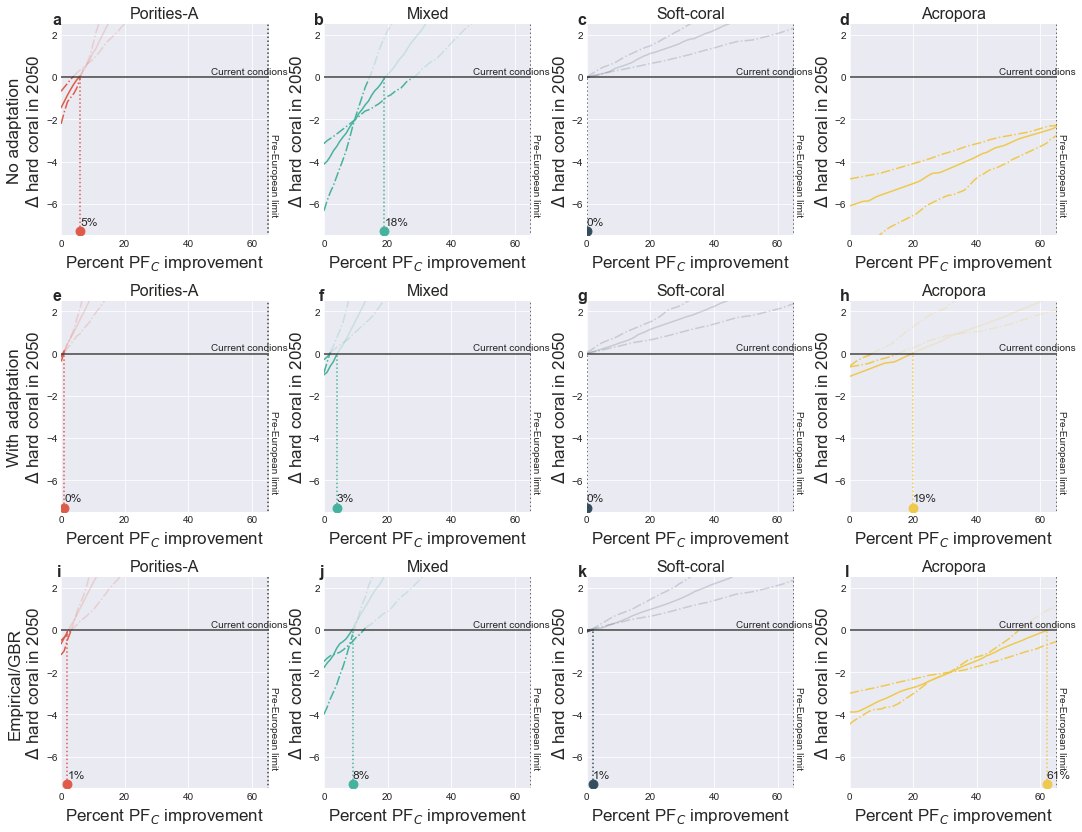

In [74]:
## 
fig = plt.figure(figsize=(15, 15))

gs = mp.gridspec.GridSpec(4, 4)
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[0,2])
ax4 = plt.subplot(gs[0,3])
ax5 = plt.subplot(gs[1,0])
ax6 = plt.subplot(gs[1,1])
ax7 = plt.subplot(gs[1,2])
ax8 = plt.subplot(gs[1,3])
ax9 = plt.subplot(gs[2,0])
ax10 = plt.subplot(gs[2,1])
ax11 = plt.subplot(gs[2,2])
ax12 = plt.subplot(gs[2,3])

ax_ = [[ax1,ax2,ax3,ax4],[ax5,ax6,ax7,ax8],[ax9,ax10,ax11,ax12]]
lett = [[a for a in 'abcd'],[a for a in 'efgh'],[a for a in 'ijkl'],[a for a in 'mnop']]
clnames = [CL1l,CL12,CL13,CL14]

# Text
axfont = 17
#setting the legend for the plot using patch
CL1l = mpatches.Patch(color=xcol[0], label=Cluster[0])
CL12 = mpatches.Patch(color=xcol[1], label=Cluster[1])
CL13 = mpatches.Patch(color=xcol[2], label=Cluster[2])
CL14 = mpatches.Patch(color=xcol[3], label=Cluster[3])
# Parms
ccx = 47
offx = 0.5
offy = .1


# Plot bleaching scenarios
# No adaptation

# = = = = = = = = = = = = = = = No adaptation = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = #
ymin = -7.5
nrecs = nlin
j = 0
for i in range(ncluster):
    ax = ax_[j][i]
    ymin = -7.5

    ynew = (HC_wq_b1[i].T[nyrs-1]-HC_wq[i][0][nyrs-1])
    ynew_l95 = (HC_wq_b1_l95[i].T[nyrs-1]-(HC_wq_l95[i][0][nyrs-1]))
    ynew_u95 = (HC_wq_b1_u95[i].T[nyrs-1]-(HC_wq_u95[i][0][nyrs-1]))
    ynew_l50 = (HC_wq_b1_l50[i].T[nyrs-1]-(HC_wq_l50[i][0][nyrs-1]))
    ynew_u50 = (HC_wq_b1_u50[i].T[nyrs-1]-(HC_wq_u50[i][0][nyrs-1]))
    nrecs = len(ynew)
    xnew = range(nrecs)

    tmp = Lndx(ynew,0)
    tmp_l95 = Lndx(ynew_l95,0)
    tmp_u95 = Lndx(ynew_u95,0)
    tmp_l50 = Lndx(ynew_l50,0)
    tmp_u50 = Lndx(ynew_u50,0)
    
    ax.scatter(xnew[tmp],ymin+.2,s=79,c=xcol[i])
    ax.plot([xnew[tmp]]*2,(ymin+.2,0),c=xcol[i],linestyle=":")
    ax.plot(xnew[:tmp+1],ynew[:tmp+1],color=xcol[i])
    ax.plot(xnew[tmp:],ynew[tmp:],alpha=0.2,color=xcol[i])

    ax.plot(xnew[:tmp_l50+1],ynew_l50[:tmp_l50+1],color=xcol[i],linestyle="-.")
    ax.plot(xnew[tmp_l50:],ynew_l50[tmp_l50:],alpha=0.2,color=xcol[i],linestyle="-.")

    ax.plot(xnew[:tmp_u50+1],ynew_u50[:tmp_u50+1],color=xcol[i],linestyle="-.")
    ax.plot(xnew[tmp_u50:],ynew_u50[tmp_u50:],alpha=0.2,color=xcol[i],linestyle="-.")

    if xnew[tmp]<1:
        ax.text(xnew[tmp],ymin+offx,'0'+'%',fontsize=12)
    elif xnew[tmp]<max_PFx:
        ax.text(xnew[tmp],ymin+offx,str(xnew[tmp-1])+'%',fontsize=12)

    ax.text(ccx,0.15,'Current condions')
    ax.set_xlabel('Percent PF$_{C}$ improvement', fontsize=axfont)
    if i==0:
        ax.set_ylabel('No adaptation\n$\Delta$ hard coral in 2050', fontsize=axfont)
    else:
        ax.set_ylabel('$\Delta$ hard coral in 2050', fontsize=axfont)
    ax.plot((-100,100),(0,0),c='0.25')
    ax.set_ylim(ymin,2.5)
    ax.set_xlim(0,max_PFx+offy)
    ax.set_title(Clust_x[i],fontsize=axfont-1)
    ax.text(0, 3.1, lett[j][i], fontsize=16, fontweight='bold', va='top', ha='right')
    ax.plot((max_PFx,max_PFx),(-100,100),c='0.25',linestyle=":")
    ax.text(max_PFx+offy,-3,'Pre-European limit',rotation=-90)

    
    
    
# = = = = = = = = = = = = = = = With adaptation = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = #
ymin = -7.5
nrecs = nlin
j = 1
for i in range(ncluster):
    ax = ax_[j][i]
    ymin = -7.5

    ynew = (HC_wq_b2[i].T[nyrs-1]-HC_wq[i][0][nyrs-1])
    ynew_l95 = (HC_wq_b2_l95[i].T[nyrs-1]-(HC_wq_l95[i][0][nyrs-1]))
    ynew_u95 = (HC_wq_b2_u95[i].T[nyrs-1]-(HC_wq_u95[i][0][nyrs-1]))
    ynew_l50 = (HC_wq_b2_l50[i].T[nyrs-1]-(HC_wq_l50[i][0][nyrs-1]))
    ynew_u50 = (HC_wq_b2_u50[i].T[nyrs-1]-(HC_wq_u50[i][0][nyrs-1]))
    nrecs = len(ynew)
    xnew = range(nrecs)

    tmp = Lndx(ynew,0)
    tmp_l95 = Lndx(ynew_l95,0)
    tmp_u95 = Lndx(ynew_u95,0)
    tmp_l50 = Lndx(ynew_l50,0)
    tmp_u50 = Lndx(ynew_u50,0)
    
    ax.scatter(xnew[tmp],ymin+.2,s=79,c=xcol[i])
    ax.plot([xnew[tmp]]*2,(ymin+.2,0),c=xcol[i],linestyle=":")
    ax.plot(xnew[:tmp+1],ynew[:tmp+1],color=xcol[i])
    ax.plot(xnew[tmp:],ynew[tmp:],alpha=0.2,color=xcol[i])

    ax.plot(xnew[:tmp_l50+1],ynew_l50[:tmp_l50+1],color=xcol[i],linestyle="-.")
    ax.plot(xnew[tmp_l50:],ynew_l50[tmp_l50:],alpha=0.2,color=xcol[i],linestyle="-.")

    ax.plot(xnew[:tmp_u50+1],ynew_u50[:tmp_u50+1],color=xcol[i],linestyle="-.")
    ax.plot(xnew[tmp_u50:],ynew_u50[tmp_u50:],alpha=0.2,color=xcol[i],linestyle="-.")

    if xnew[tmp]<1:
        ax.text(xnew[tmp],ymin+offx,'0'+'%',fontsize=12)
    elif xnew[tmp]<max_PFx:
        ax.text(xnew[tmp],ymin+offx,str(xnew[tmp-1])+'%',fontsize=12)

    ax.text(ccx,0.15,'Current condions')
    ax.set_xlabel('Percent PF$_{C}$ improvement', fontsize=axfont)
    if i==0:
        ax.set_ylabel('With adaptation\n$\Delta$ hard coral in 2050', fontsize=axfont)
    else:
        ax.set_ylabel('$\Delta$ hard coral in 2050', fontsize=axfont)
    ax.plot((-100,100),(0,0),c='0.25')
    ax.set_ylim(ymin,2.5)
    ax.set_xlim(0,max_PFx+offy)
    ax.set_title(Clust_x[i],fontsize=axfont-1)
    ax.text(0, 3.1, lett[j][i], fontsize=16, fontweight='bold', va='top', ha='right')
    ax.plot((max_PFx,max_PFx),(-100,100),c='0.25',linestyle=":")
    ax.text(max_PFx+offy,-3,'Pre-European limit',rotation=-90)
    

    
    
    
# = = = = = = = = = = = = = = = Empirical/GBR = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = #
ymin = -7.5
nrecs = nlin
j = 2
for i in range(ncluster):
    ax = ax_[j][i]
    ymin = -7.5
    
    ynew = np.array([np.mean((x,y)) for x,y in zip(HC_wq_b3[i].T[nyrs-1],HC_wq_b4[i].T[nyrs-1])]-HC_wq[i][0][nyrs-1])
    ynew_l95 = np.array([min((x,y)) for x,y in zip(HC_wq_b3_l95[i].T[nyrs-1],HC_wq_b4_l95[i].T[nyrs-1])]-HC_wq_l95[i][0][nyrs-1])
    ynew_u95 = np.array([min((x,y)) for x,y in zip(HC_wq_b3_u95[i].T[nyrs-1],HC_wq_b4_u95[i].T[nyrs-1])]-HC_wq_u95[i][0][nyrs-1])
    ynew_l50 = np.array([min((x,y)) for x,y in zip(HC_wq_b3_l50[i].T[nyrs-1],HC_wq_b4_l50[i].T[nyrs-1])]-HC_wq_l50[i][0][nyrs-1])
    ynew_u50 = np.array([min((x,y)) for x,y in zip(HC_wq_b3_u50[i].T[nyrs-1],HC_wq_b4_u50[i].T[nyrs-1])]-HC_wq_u50[i][0][nyrs-1])
    nrecs = len(ynew)
    xnew = range(nrecs)

    tmp = Lndx(ynew,0)
    tmp_l95 = Lndx(ynew_l95,0)
    tmp_u95 = Lndx(ynew_u95,0)
    tmp_l50 = Lndx(ynew_l50,0)
    tmp_u50 = Lndx(ynew_u50,0)
    
    ax.scatter(xnew[tmp],ymin+.2,s=79,c=xcol[i])
    ax.plot([xnew[tmp]]*2,(ymin+.2,0),c=xcol[i],linestyle=":")
    ax.plot(xnew[:tmp+1],ynew[:tmp+1],color=xcol[i])
    ax.plot(xnew[tmp:],ynew[tmp:],alpha=0.2,color=xcol[i])

    ax.plot(xnew[:tmp_l50+1],ynew_l50[:tmp_l50+1],color=xcol[i],linestyle="-.")
    ax.plot(xnew[tmp_l50:],ynew_l50[tmp_l50:],alpha=0.2,color=xcol[i],linestyle="-.")

    ax.plot(xnew[:tmp_u50+1],ynew_u50[:tmp_u50+1],color=xcol[i],linestyle="-.")
    ax.plot(xnew[tmp_u50:],ynew_u50[tmp_u50:],alpha=0.2,color=xcol[i],linestyle="-.")
    
    #ax.plot(xnew[:tmp_l95+1],ynew_l95[:tmp_l95+1],color=xcol[i],linestyle="-.")
    #ax.plot(xnew[tmp_l95:],ynew_l95[tmp_l95:],alpha=0.2,color=xcol[i],linestyle="-.")

    #ax.plot(xnew[:tmp_u95+1],ynew_u95[:tmp_u95+1],color=xcol[i],linestyle="-.")
    #ax.plot(xnew[tmp_u95:],ynew_u95[tmp_u95:],alpha=0.2,color=xcol[i],linestyle="-.")

    if xnew[tmp]<1:
        ax.text(xnew[tmp],ymin+offx,'0'+'%',fontsize=12)
    elif xnew[tmp]<max_PFx:
        ax.text(xnew[tmp],ymin+offx,str(xnew[tmp-1])+'%',fontsize=12)

    ax.text(ccx,0.15,'Current condions')
    ax.set_xlabel('Percent PF$_{C}$ improvement', fontsize=axfont)
    if i==0:
        ax.set_ylabel('Empirical/GBR\n$\Delta$ hard coral in 2050', fontsize=axfont)
    else:
        ax.set_ylabel('$\Delta$ hard coral in 2050', fontsize=axfont)
    ax.plot((-100,100),(0,0),c='0.25')
    ax.set_ylim(ymin,2.5)
    ax.set_xlim(0,max_PFx+offy)
    ax.set_title(Clust_x[i],fontsize=axfont-1)
    ax.text(0, 3.1, lett[j][i], fontsize=16, fontweight='bold', va='top', ha='right')
    ax.plot((max_PFx,max_PFx),(-100,100),c='0.25',linestyle=":")
    ax.text(max_PFx+offy,-3,'Pre-European limit',rotation=-90)
    
plt.tight_layout()
fig.savefig('Figure_S6.pdf');

# Plot PFc surface

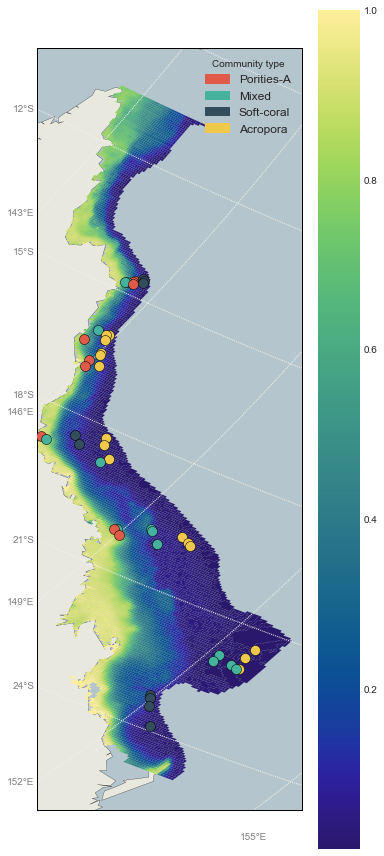

In [75]:
fig = plt.figure(figsize=(5, 12))

gs = mp.gridspec.GridSpec(1, 1, width_ratios=[1])
ax1 = fig.add_subplot(gs[:])

# = = = = = = = = = = = = = = = = = = = MAP = = = = = = = = = = = = = = = = = = = #
# Lat/longitudes
ymin, ymax = (-26.5,-8)
xmin, xmax = (153,145)
xmin = xmin-.5


# Map projection
mapx = bm(projection='rotpole',o_lat_p=132,o_lon_p=50,lon_0=0,llcrnrlat=ymin, llcrnrlon=xmin,urcrnrlon=xmax,urcrnrlat=ymax, resolution='l',ax=ax1)


# Draw map
mapx.drawmeridians(np.arange(110,190,3),labels=[1,0,0,1],fontsize=10,color='#f3f3e9', alpha=0.5)
mapx.drawparallels(np.arange(-30,17,3),labels=[1,0,0,0],fontsize=10,color='#f3f3e9', alpha=0.5)
mapx.drawcoastlines(linewidth=0.25)
mapx.drawcountries(linewidth=0.25)
mapx.drawmapboundary(fill_color='#b5c5cd')
mapx.fillcontinents(color='#e9e8df')

# Grab water quality shapefile
mapx.readshapefile('PST_Sum/idw_pst_clip_final_vector', 'idw_pst_clip_final_vector',color='#f3f3e9', drawbounds=False)

patches   = []
cmap=cmo.cm.haline
iPFc = np.array([x['PST_Freq'] for x in mapx.idw_pst_clip_final_vector_info])

for info, shape in zip(mapx.idw_pst_clip_final_vector_info, mapx.idw_pst_clip_final_vector):
    patches.append( Polygon(np.array(shape), True) )
    
ptx = PatchCollection(patches, facecolor=cmap(iPFc), edgecolor='k', linewidths=0., zorder=2)
ax1.add_collection(ptx)

ptx.set_array(np.array(iPFc))
ptx.set_clim([np.ma.min(iPFc),np.ma.max(iPFc)])
ptx.cmap = cmap
plt.colorbar(ptx)

# Legend
#setting the legend for the plot using patch
CL1l = mpatches.Patch(color=xcol[0], label=Cluster[0])
CL12 = mpatches.Patch(color=xcol[1], label=Cluster[1])
CL13 = mpatches.Patch(color=xcol[2], label=Cluster[2])
CL14 = mpatches.Patch(color=xcol[3], label=Cluster[3])
ax1.legend(handles=[CL1l,CL12,CL13,CL14],title='Community type', loc=1, fontsize=12)

# Plot points
X,Y = mapx(xlon,xlat)
[mapx.scatter(x, y, c=c, s=100, edgecolor='black', linewidth='.5', zorder=3) for x,y,c in zip(X,Y,C)];

plt.tight_layout()
fig.savefig('Figure_S5.pdf');